# Simulated Maximum likelihood

This notebook simulates panel dataset from the model 
$$ 
y_{it} = \mathbf{x}_{it} \boldsymbol{\beta} + c_i + u_{it},  \quad c_i \sim \text{IID}\mathcal{N}(0,\sigma_c^2), \quad u_{it} \sim \text{IID}\mathcal{N}(0,\sigma_u^2).
$$

The likelihood function needs to integrate out the unobserved $c_i$, taking the form 
$$
\ell_i(\theta) = \log \int \prod_{t=1}^T \frac{1}{\sigma_u} \phi\left( \frac{y_{it} - \mathbf{x}_{it} \boldsymbol{\beta} - \sigma_c c}{\sigma_u} \right) \phi(c) \text{d} c.
$$

The integral (the expectation wrt. $c_i$) can be computed either using *simulation* or *quadrature*. Both are *approximations* to the integral.

* **Simulation:** Take $R$ draws, $c^{(r)} \sim \mathcal{N}(0,1)$, and compute 
$$
\ell_i(\theta) \cong \log R^{-1}\sum_{r=1}^R  \left[ \prod_{t=1}^T \frac{1}{\sigma_u} \phi\left( \frac{y_{it} - \mathbf{x}_{it} \boldsymbol{\beta} - \sigma_c \color{red}{ c^{(r)}} }{\sigma_u} \right) \right].
$$
By the Law of Large Numbers, the average of the $R$ draws converges to the corresponding expectation as $R \to \infty$. 
    * (The draws can either be the same for all $i$ or different for each. There are even ways of using *quasi-random* draws that have proven better coverage as a way of reducing the $R$ required to achieve a precise approximation of the integral with the simulated average.) 
* **Quadrature:** using $Q$ quadrature nodes and weights, $\{n_q, w_q\}_{q=1}^Q$, compute
$$
\ell_i(\theta) \cong \log \sum_{q=1}^Q \color{red}{w_q}  \left[ \prod_{t=1}^T \frac{1}{\sigma_u} \phi\left( \frac{y_{it} - \mathbf{x}_{it} \boldsymbol{\beta} - \sigma_c \color{red}{n_q} }{\sigma_u} \right) \right].
$$
    * In practice, quadrature works very well and can (for 1-dimensional integrals) achieve superior precision to simulation for a smaller computational costs (i.e. for $Q<R$).

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
sns.set_theme()

%load_ext autoreload
%autoreload 2

import sml 
import estimation

In [2]:
n,w = sml.get_quadrature_data(25)

In [3]:
np.random.seed(1)
N = 100
T = 10 

In [4]:
betao = np.array([1.,1.])
K = betao.size
sigma_c = 1.
sigma_u = 1.
thetao = np.append(betao, [sigma_u, sigma_c])
y,x,c = sml.sim_data(thetao, N, T)
# note: it is "cheating" that we return c, since in a real 
# dataset we do not observe c; here, it is done so that we 
# can make illustrative plots

## Some illustrations

In [5]:
x = x.reshape(N*T,K)
y = y.reshape(N*T,)
c = np.kron(c.flatten(), np.ones((T,)))

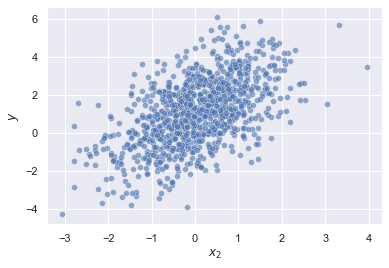

In [6]:
ax = sns.scatterplot(x=x[:, 1], y=y, alpha=0.6);
ax.set_xlabel('$x_2$'); ax.set_ylabel('$y$');
#plt.savefig('img/data.pdf');

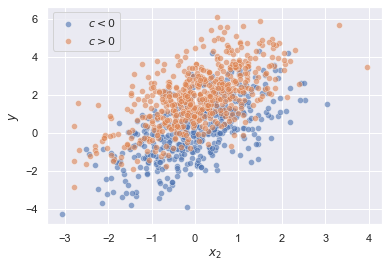

In [7]:
I = c<0
ax = sns.scatterplot(x=x[I, 1], y=y[I], alpha=0.6);
I = c >= 0
sns.scatterplot(x=x[I, 1], y=y[I], alpha=0.6, ax=ax);
ax.legend(['$c<0$', r'$c > 0$']); 
ax.set_xlabel('$x_2$'); ax.set_ylabel('$y$');
#plt.savefig('img/data_sub_c.pdf')

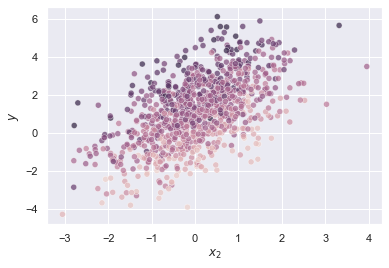

In [8]:
ax = sns.scatterplot(x=x[:, 1], y=y, hue=c, alpha=0.7);
ax.set_xlabel('$x_2$'); ax.set_ylabel('$y$');
ax.legend().remove();
#plt.savefig('img/data_colored_by_c.pdf')

In [9]:
def pred(y,x): 
    b_ols = np.linalg.solve(x.T@x, x.T@y)
    return x@b_ols

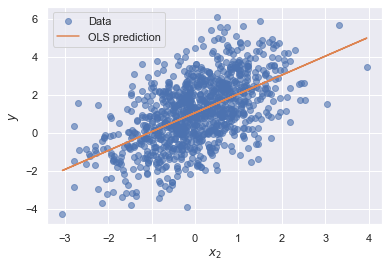

In [10]:
fig,ax = plt.subplots(); 
ax.plot(x[:,1], y, 'o', alpha=0.6, label='Data');
ax.plot(x[:,1], pred(y,x), '-', alpha=1.0, label='OLS prediction');
ax.set_xlabel('$x_2$'); ax.set_ylabel('$y$');
ax.legend();
#plt.savefig('img/pooled_ols_predict.pdf');

In [11]:
cols = sns.color_palette()

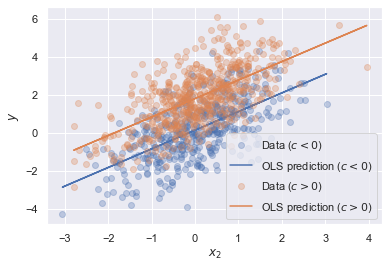

In [12]:
fig,ax = plt.subplots(); 

I = c<0
ax.plot(x[I,1], y[I], 'o', alpha=0.3, label='Data ($c<0$)', color=cols[0]);
ax.plot(x[I,1], pred(y[I],x[I]), '-', alpha=1.0, label='OLS prediction ($c<0$)', color=cols[0]);

I = c>=0
ax.plot(x[I,1], y[I], 'o', alpha=0.3, label='Data ($c>0$)', color=cols[1]);
ax.plot(x[I,1], pred(y[I],x[I]), '-', alpha=1.0, label='OLS prediction ($c>0$)', color=cols[1]);

ax.set_xlabel('$x_2$'); ax.set_ylabel('$y$');
ax.legend();
#plt.savefig('img/pooled_ols_predict_sub_c.pdf');

## Reset dimensions

In [13]:
x = x.reshape(N,T,K)
y = y.reshape(N,T)

# Simulation or quasi-random draws? 

Rather than actually drawing from a random normal distribution, we can also just choose an equi-probable grid over $[0;1]$ and then pick $\Phi^{-1}(u)$ for each of these draws as our random normal draw. In practice, there are even better ways of "choosing the draws" so that they are "as randomly normal as possible." 

In [14]:
from scipy.stats import norm

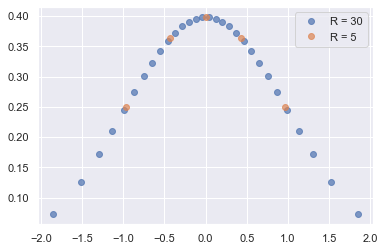

In [15]:
fig,ax = plt.subplots();
for R in [30, 5]:
    nn = sml.draw_c(1.0, 1, R).flatten()
    ax.plot(nn, norm.pdf(nn), 'o', label=f'R = {R}', alpha=0.7);
ax.legend();

# Estimating on simulated data

## Estimate with simulation

Here, we estimate the model using the criterion function where we compute the integral by simulation. 

* `seed = None`: Deterministic draws
* `seed = 1`: `numpy.random.normal` draws (seeded)

Finding: We require $R \ge 100$ before any kind of precision in our integration sets in. 

In [16]:
R = 100
theta0 = thetao*1.0
q = lambda theta,y,x : sml.q(theta, y, x, R=R, seed=None) # seed=None: use equiprobably grid points on (0;1)
res = estimation.estimate(q, theta0, y, x)

pd.DataFrame({'start': theta0, 
              'truth': thetao,
              'thetahat': res['theta'],
              't': res['t']}, 
            index=['beta1', 'beta2', 'sigma_c', 'sigma_u']).round(4)

Optimization terminated successfully.
         Current function value: 15.619816
         Iterations: 7
         Function evaluations: 50
         Gradient evaluations: 10


,start,truth,thetahat,t
beta1,1.0,1.0,1.0590,9.5768
beta2,1.0,1.0,0.9781,27.2558
sigma_c,1.0,1.0,1.0224,40.5257
sigma_u,1.0,1.0,1.0597,12.4328


***Warning!*** There is upwards bias in the estimate of sigma_u! Increasing `R` brings the estimate closer to the truth. 

## Estimate with Quadrature

Now, we compute the integral by *quadrature* instead. 

In [17]:
R = 20 # no. quadrature points 
theta0 = thetao*1.0
q = lambda theta,y,x : -sml.loglikelihood_quad(theta, y, x, R) 
res = estimation.estimate(q, theta0, y, x)

pd.DataFrame({'start': theta0, 
              'truth': thetao,
              'thetahat': res['theta'],
              't': res['t']}, 
            index=['beta1', 'beta2', 'sigma_c', 'sigma_u']).round(4)

Optimization terminated successfully.
         Current function value: 18.619909
         Iterations: 6
         Function evaluations: 45
         Gradient evaluations: 9


,start,truth,thetahat,t
beta1,1.0,1.0,1.0507,9.7926
beta2,1.0,1.0,0.9756,27.4380
sigma_c,1.0,1.0,1.0213,41.1359
sigma_u,1.0,1.0,1.0529,11.6141


### Visualizing quadrature nodes and weights

The nodes and weights are set in a "smart way". Smart people have derived how to choose $\{n_q, w_q\}_{q=1}^Q$, such that the approximation, 
$$
\int_{-\infty}^\infty g(x) \phi(x) \text{d}x \cong \sum_{q=1}^Q w_q  g(n_q),
$$
is as good as possible.

Let's see what they look like. 

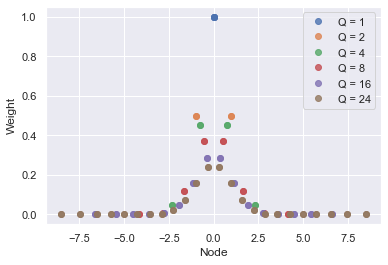

In [18]:
fig,ax = plt.subplots();
for Q in [1,2,4,8,16,24]:
    n,w = sml.get_quadrature_data(Q)
    n = np.hstack([-np.flip(n), n])
    w = np.hstack([np.flip(w), w])
    ax.plot(n, w, 'o', label=f'Q = {Q}', alpha=0.8)
ax.legend();
ax.set_xlabel('Node'); ax.set_ylabel('Weight');

#plt.savefig('img/quadrature.pdf'); 